In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [2]:
import numpy as np
import pandas as pd

# Nur erste Zeilen laden, um Spalten zu inspizieren
df_preview_ratings = pd.read_csv("Books_rating.csv", nrows=5)
df_preview_data = pd.read_csv("books_data.csv", nrows=5)
print(df_preview_ratings.columns)
print(df_preview_data.columns)


Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')
Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount'],
      dtype='object')


In [3]:
# Nur relevante Spalten laden
ratings_cols = ["Id", "Title", "User_id", "review/score", "review/summary", "review/text"]
data_cols = ["Title", "description", "authors", "categories"]

# CSV-Dateien laden
ratings = pd.read_csv("Books_rating.csv")
books = pd.read_csv("books_data.csv")

In [4]:
# Überblick
print("🧾 Ratings Shape:", ratings.shape)
print("📚 Books Shape:", books.shape)

# Vorschau
print("\n🔍 Ratings Vorschau (relevant):")
print(ratings[ratings_cols].head())

print("\n🔍 Books Vorschau (relevant):")
print(books[data_cols].head())

# Duplikate direkt entfernen
books = books.drop_duplicates()
ratings = ratings.drop_duplicates()

# Fehlende Werte
print("\n🧹 Fehlende Werte in Ratings:")
print(ratings.isnull().sum())

print("\n🧹 Fehlende Werte in Books:")
print(books.isnull().sum())

# Einfache Statistik zu Bewertungen
print("\n📊 Bewertungsskala:")
print(ratings["review/score"].value_counts().sort_index())

# Top 5 häufigste Titel (evtl. Duplikate oder Mehrfachbewertungen)
print("\n📈 Top 5 bewertete Titel:")
print(ratings["Title"].value_counts().head())

# Anzahl eindeutiger Bücher und Nutzer
print("\n👥 Eindeutige Nutzer:", ratings["User_id"].nunique())
print("📖 Eindeutige Buchtitel:", ratings["Title"].nunique())

# Doppelte Bewertungen vom gleichen Nutzer des gleichen Titels (ratings)
dupes = ratings.duplicated(subset=["User_id", "Title"], keep=False)
print("🔁 Doppelte Bewertungen (gleicher Nutzer & Titel):", dupes.sum())

# Doppelte Buchtitel (books)
print("📚 Doppelte Titel:", books["Title"].duplicated().sum())



🧾 Ratings Shape: (3000000, 10)
📚 Books Shape: (212404, 10)

🔍 Ratings Vorschau (relevant):
           Id                           Title         User_id  review/score  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD           4.0   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R           5.0   
2  0826414346        Dr. Seuss: American Icon  A3UH4UZ4RSVO82           5.0   
3  0826414346        Dr. Seuss: American Icon  A2MVUWT453QH61           4.0   
4  0826414346        Dr. Seuss: American Icon  A22X4XUPKF66MR           4.0   

                                    review/summary  \
0           Nice collection of Julie Strain images   
1                                Really Enjoyed It   
2  Essential for every personal and Public Library   
3  Phlip Nel gives silly Seuss a serious treatment   
4                           Good academic overview   

                                         review/text  
0  This is only for Julie Strain fans. It's a col...  

Erkenntnisse Ratings: 
- Alle Einträge ohne User_id wertlos, da aus Sicht eines Users ein Buch empfohlen werden soll -> rausschmeißen
- Ratings werden über Buchtitel mit Buchdata gemappt, daher diese Einträge ebenfalls rauswerfen
- fehlende Einträge mit Reviews rauswerfen, Review Summary nicht weiter als relevant betrachten

Erkenntnisse Data: 
- supe viele fehlende Daten (description, authors, categories) - da feature vektor kombination aus allen 3 drin lassen und mit leerem Text auffüllen, in der hoffnung, dass so info erhalten bleibt

Doppelte Bewertungen (Nutzer und Titel mal genauer ansehen)

In [5]:
# Bereinigung Bücher
ratings = ratings.dropna(subset=["User_id", "Title", "review/text"])
ratings["review/summary"] = ratings["review/summary"].fillna("")

# Bereinigung Data

# Titel muss vorhanden sein
books = books.dropna(subset=["Title"])

# Leere Inhalte ersetzen durch leeren String
books["description"] = books["description"].fillna("")
books["authors"] = books["authors"].fillna("")
books["categories"] = books["categories"].fillna("")

# Doppelte Einträge nach User_id + Title
duplicate_mask = ratings.duplicated(subset=["User_id", "Title"], keep=False)

# Zeilen mit doppelten Bewertungen filtern
duplicates = ratings[duplicate_mask]

# 20 Duplikate
duplicates.sort_values(by=["User_id", "Title"]).head(20)


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1483705,B0007G66WI,The richest man in Babylon,NaN,A0015610VMNR0JC9XVL1,ivan kaye,0/0,5.0,1358985600,best book to show you how to grow wealth!,best book to show you how to grow wealth! Have...
2639269,B0007DRIT6,The richest man in Babylon,NaN,A0015610VMNR0JC9XVL1,ivan kaye,0/0,5.0,1358985600,best book to show you how to grow wealth!,best book to show you how to grow wealth! Have...
2839481,B0000CJ9GZ,The richest man in Babylon,NaN,A0015610VMNR0JC9XVL1,ivan kaye,0/0,5.0,1358985600,best book to show you how to grow wealth!,best book to show you how to grow wealth! Have...
413239,B000NDSX6C,The Hobbit,NaN,A00540411RKGTDNU543WS,Keith Smith,1/1,5.0,1360454400,GREAT!,Awesome! After watching the first part in the ...
856393,B000NWQXBA,The Hobbit,NaN,A00540411RKGTDNU543WS,Keith Smith,1/1,5.0,1360454400,GREAT!,Awesome! After watching the first part in the ...
1683081,B000PC54NG,The Hobbit,NaN,A00540411RKGTDNU543WS,Keith Smith,1/1,5.0,1360454400,GREAT!,Awesome! After watching the first part in the ...
2492281,B000GQG7D2,The Hobbit,NaN,A00540411RKGTDNU543WS,Keith Smith,1/1,5.0,1360454400,GREAT!,Awesome! After watching the first part in the ...
2943410,B000H9R1Q0,The Hobbit,NaN,A00540411RKGTDNU543WS,Keith Smith,1/1,5.0,1360454400,GREAT!,Awesome! After watching the first part in the ...
1134995,0385187157,Anne Frank's Tales from the Secret Annex,NaN,A00787411M1CAS4K6H99N,Kimzer18!,0/0,5.0,1351123200,I love this book,This book was great.I will reread it alot. i b...
2527349,1417617772,Anne Frank's Tales from the Secret Annex,NaN,A00787411M1CAS4K6H99N,Kimzer18!,0/0,5.0,1351123200,I love this book,This book was great.I will reread it alot. i b...


Doppelte Bewertungen können alle raus, vorsichtig bereinigen über "User_id", "Title", "review/text"

In [6]:
ratings = ratings.drop_duplicates(subset=["User_id", "Title", "review/text"])
dupes = ratings.duplicated(subset=["User_id", "Title"], keep=False)
print("🔁 Verbleibende doppelte Bewertungen (User + Title):", dupes.sum())

🔁 Verbleibende doppelte Bewertungen (User + Title): 31004


In [7]:
# Zeige Beispiel-Duplikate nach der Bereinigung
ratings[dupes].sort_values(by=["User_id", "Title"]).head(10)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
107000,0671641050,Lover,NaN,A1009L3XQBX5GJ,"J.L. Rollins ""J. L. Rollins""",1/2,5.0,1021334400,"SUPERIOR,A PERFECT MASTERPIECE,VISUALLY STUNNI...",The Lover is DROP DEAD GORGEAUS. This novel is...
107024,0671641050,Lover,NaN,A1009L3XQBX5GJ,"J.L. Rollins ""J. L. Rollins""",3/7,5.0,1021248000,"SUPERIOR,A PERFECT MASTERPIECE,VISUALLY STUNNI...",The Lover is DROP DEAD GORGEAUS. This novel is...
107055,0671641050,Lover,NaN,A1009L3XQBX5GJ,"J.L. Rollins ""J. L. Rollins""",18/22,5.0,1021248000,"SUPERIOR,A PERFECT MASTERPIECE,VISUALLY STUNNI...",The Lover is DROP DEAD GORGEAUS. This novel is...
948045,0071456848,McGraw-Hill's GMAT with CD-Rom (McGraw-Hill's ...,NaN,A100C7HR4MOL05,Brian Aldershof,3/3,1.0,1167264000,Not a good choice,I reviewed this book for the book with no CD-R...
948046,0071456848,McGraw-Hill's GMAT with CD-Rom (McGraw-Hill's ...,NaN,A100C7HR4MOL05,Brian Aldershof,2/2,1.0,1167091200,Lots of errata,"The format of this book is nice, but it is fil..."
2570796,1888451327,High Life (Little House on the Bowery),NaN,A101643JKRQ1RI,Josh Lewis,13/18,5.0,1038960000,WEEEE,"matthew stokoe is an amazing writer.in cows, h..."
2570812,1888451327,High Life (Little House on the Bowery),NaN,A101643JKRQ1RI,Josh Lewis,6/14,5.0,1039478400,WEEEE,"matthew stokoe is an amazing writer.in cows, h..."
2313142,0330437437,"Little Piece of Ground, A",NaN,A101BPUBYQZ989,Chris JJ,8/8,5.0,1130544000,A very human story exposing the tyranny of occ...,"A touching novel, written for young adults but..."
2313161,0330437437,"Little Piece of Ground, A",NaN,A101BPUBYQZ989,Chris JJ,22/23,5.0,1157587200,A very human story exposing the tyranny of occ...,"A touching novel, written for young adults but..."
2909878,0439339189,"The Trail of the Jedi (Star Wars: Jedi Quest, ...",NaN,A101GRTZOS8B5G,James D. Ray,2/3,3.0,1026691200,"Excellent, even for an older reader","I'm 25, and although these books are written f..."


immernoch trash

In [8]:
ratings = ratings.drop_duplicates(subset=["User_id", "Title"])
dupes = ratings.duplicated(subset=["User_id", "Title"], keep=False)
print("🔁 Verbleibende doppelte Bewertungen (User + Title):", dupes.sum())

# Überblick
print("🧾 Ratings Shape neu:", ratings.shape)
print("📚 Books Shape neu:", books.shape)

🔁 Verbleibende doppelte Bewertungen (User + Title): 0
🧾 Ratings Shape neu: (2115810, 10)
📚 Books Shape neu: (212403, 10)


Content based 

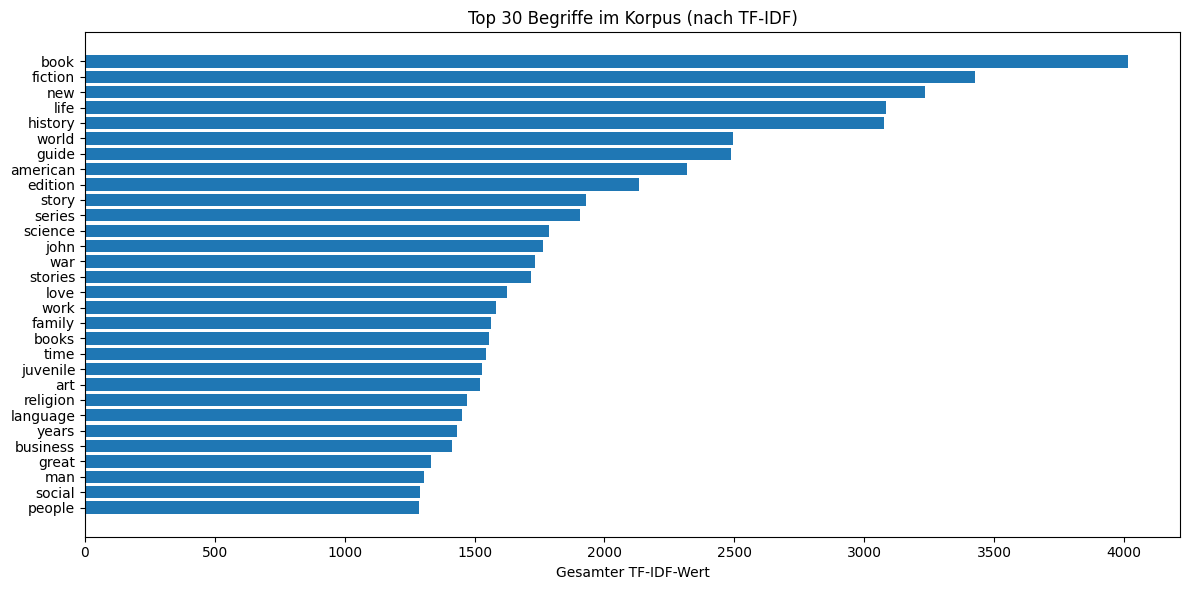

In [9]:
# Kombinierte Textfeatures erzeugen
books["combined_features"] = (
    books["Title"] + " " +
    books["authors"] + " " +
    books["categories"] + " " +
    books["description"]
).str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True)

# TF-IDF-Vektorisierung
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(books["combined_features"])

# Summe der TF-IDF-Werte je Wort über alle Dokumente
tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
feature_names = tfidf.get_feature_names_out()

# Top-N Begriffe mit höchster Gesamt-TF-IDF
top_n = 30
top_indices = tfidf_sum.argsort()[::-1][:top_n]

top_features = [feature_names[i] for i in top_indices]
top_scores = tfidf_sum[top_indices]

# Visualisierung
plt.figure(figsize=(12, 6))
plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Gesamter TF-IDF-Wert")
plt.title(f"Top {top_n} Begriffe im Korpus (nach TF-IDF)")
plt.tight_layout()
plt.show()



- book sehr hoch gewichtet, vermutlich aber eher redundant -> ausschließen
- analog custom_stopwords = ["book", "books", "guide", "edition", "series", "new"]

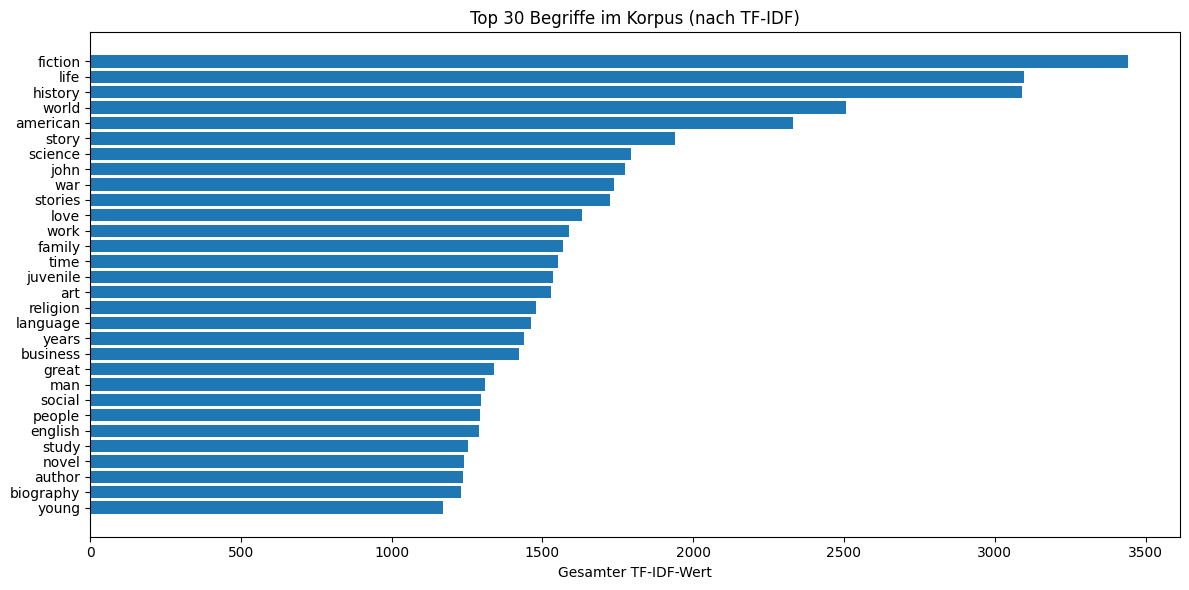

In [10]:
custom_stopwords = ["book", "books", "guide", "edition", "series", "new"]
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))

tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000)
tfidf_matrix = tfidf.fit_transform(books["combined_features"])

# Summe der TF-IDF-Werte je Wort über alle Dokumente
tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
feature_names = tfidf.get_feature_names_out()

# Top-N Begriffe mit höchster Gesamt-TF-IDF
top_n = 30
top_indices = tfidf_sum.argsort()[::-1][:top_n]

top_features = [feature_names[i] for i in top_indices]
top_scores = tfidf_sum[top_indices]

# Visualisierung
plt.figure(figsize=(12, 6))
plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Gesamter TF-IDF-Wert")
plt.title(f"Top {top_n} Begriffe im Korpus (nach TF-IDF)")
plt.tight_layout()
plt.show()


In [11]:
# Funktion: Ähnliche Bücher zu einem gegebenen Titel finden
def get_similar_books(title, books_df, tfidf_matrix, top_n=10):
    # Titel zu Index mappen
    indices = pd.Series(books_df.index, index=books_df["Title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        return f"Titel '{title}' nicht gefunden."

    # Vektor des Zielbuchs extrahieren
    book_vec = tfidf_matrix[idx]

    # Ähnlichkeiten berechnen (nur zu diesem Buch!)
    sim_scores = cosine_similarity(book_vec, tfidf_matrix).flatten()

    # Top-N ähnlichen Bücher holen (ohne sich selbst)
    similar_indices = sim_scores.argsort()[::-1][1:top_n+1]

    # Ausgabe
    result = books_df.iloc[similar_indices][["Title", "authors", "categories"]].copy()
    result["Ähnlichkeit"] = sim_scores[similar_indices]
    return result

def get_random_book_title(books_df):
    """Gibt den echten Titel (ohne Formatierung) aus."""
    return books_df["Title"].sample(1).values[0]

Anwendung

In [12]:
title = get_random_book_title(books)
print("📘 Zufallsbuch:", title)

# Jetzt echte Empfehlung dazu
get_similar_books(title, books, tfidf_matrix)

📘 Zufallsbuch: Dr. William Smith's Dictionary of the Bible: Comprising its antiquities, biography, geography, and natural history


,Title,authors,categories,Ähnlichkeit
54961,A Shakespeare Glossary,['Charles Talbut Onions'],['Drama'],1.000000
87301,"A Shakespeare glossary,",,,0.638554
82831,The Two Gentlemen of Verona (Arkangel Shakespe...,,,0.608723
75474,SHAKESPEARE BY ANOTHER NAME,,,0.608723
138079,Northrop Frye on Shakespeare,,,0.608723
19453,Hamlet the Inessential Shakespeare: Shakespear...,"['John Hort', 'Leela Hort']",['Drama'],0.589488
114421,The annotated Shakespeare,['William Shakespeare'],['English drama'],0.554404
138763,Pericles (Arkangel Complete Shakespeare Series),['William Shakespeare'],,0.551278
85395,Antony and Cleopatra (Arkangel Complete Shakes...,['William Shakespeare'],,0.551278
159468,Works of Shakespeare,['William Shakespeare'],,0.548530


Nächste Schritte: 

- nur Bücher drin lassen, die eine Description haben
- evtl. Rezensionen mit aufnehmen

In [13]:
# merge books_data.csv mit Books_rating.csv
combined = pd.merge(books, ratings, on="Title", how="inner")

# Rezensionen je Buch aggregieren (alle Rezensionen zu einem Titel zusammenfügen)
review_texts = combined.groupby("Title")["review/text"].apply(lambda x: " ".join(x)).reset_index()
books = books.merge(review_texts, on="Title", how="left")
books["review/text"] = books["review/text"].fillna("")

# in Vektor einbauen
books["combined_features"] = (
    books["Title"] + " " +
    books["authors"] + " " +
    books["categories"] + " " +
    books["description"] + " " +
    books["review/text"]
).str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True)



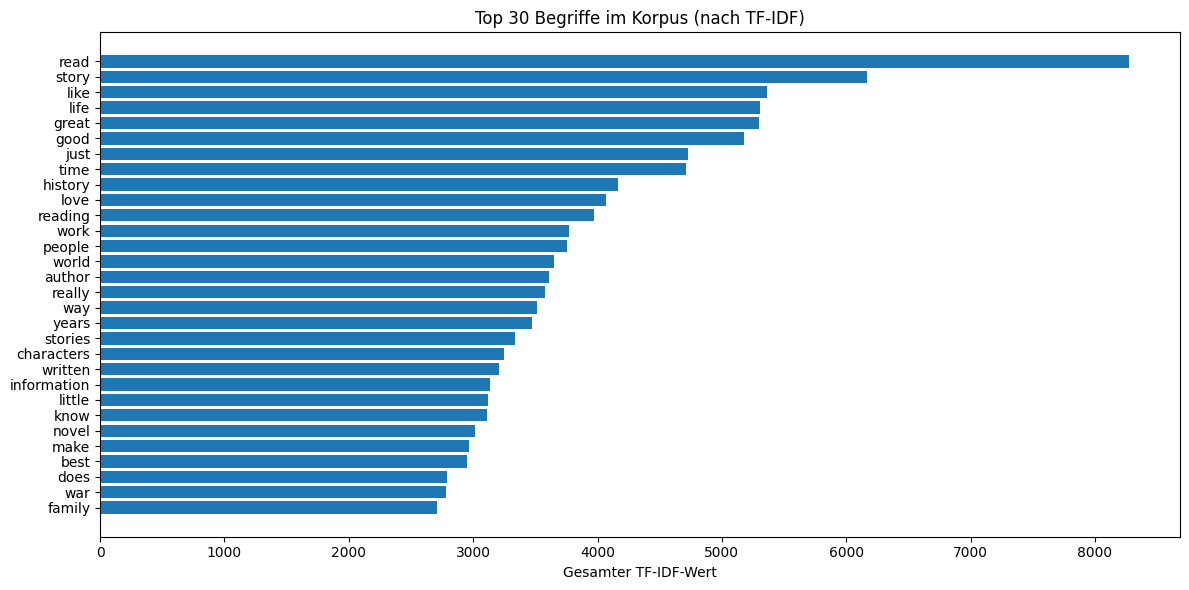

In [14]:
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000, max_df=0.8, min_df=5) #Wörter, die in über 80% der Dokumente vorkommen, ignorieren, da Füllwörter etc.
tfidf_matrix = tfidf.fit_transform(books["combined_features"])

tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
feature_names = tfidf.get_feature_names_out()

# Top-N Begriffe mit höchster Gesamt-TF-IDF
top_n = 30
top_indices = tfidf_sum.argsort()[::-1][:top_n]

top_features = [feature_names[i] for i in top_indices]
top_scores = tfidf_sum[top_indices]

# Visualisierung
plt.figure(figsize=(12, 6))
plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Gesamter TF-IDF-Wert")
plt.title(f"Top {top_n} Begriffe im Korpus (nach TF-IDF)")
plt.tight_layout()
plt.show()


In [15]:
title = get_random_book_title(books)
print("📘 Zufallsbuch:", title)

# Empfehlung dazu
get_similar_books(title, books, tfidf_matrix)

📘 Zufallsbuch: Sorcerers of Pan Tang (Stormbringer RPG)


,Title,authors,categories,Ähnlichkeit
121890,Wizardry & Wild Romance,['C. M. Waggoner'],['Fiction'],0.397052
163474,Songs of Earth & Power: The Infinity Concerto ...,['Anna L. Wood'],['Music'],0.369085
50509,Elric: Stealer of Souls (The Tale of the Etern...,['Michael Moorcock'],['Fiction'],0.368261
197676,Fantasy of the 20TH Century,['Randy Broecker'],['Fantasy fiction'],0.367111
95944,A CENTURY OF FANTASY 1980-1989: The Greatest S...,"['Robert Silverberg', 'Martin Harry Greenberg']",['Fiction'],0.348100
100163,Magician,['Raymond E. Feist'],['Fiction'],0.345943
65637,"The Complete Guide to Writing Fantasy, Vol. 1:...",['Allison Saft'],['Young Adult Fiction'],0.340678
34475,"The Pastel City (Virconium, Book One)",['Michael John Harrison'],"['Fantasy fiction, English']",0.340298
117607,The Pastel City,['Michael John Harrison'],,0.334977
2602,Kirith Kirin,['Jim Grimsley'],['Fiction'],0.330496


In [16]:
# Relevante Textspalten definieren
text_columns = ["Title", "authors", "categories", "description", "review/text"]

# Fehlende Werte durch leeren String ersetzen & in Strings umwandeln
for col in text_columns:
    books[col] = books[col].fillna("").astype(str)

# Länge jeder Textspalte (in Zeichen) berechnen
for col in text_columns:
    books[f"len_{col}"] = books[col].str.len()

# Durchschnittslängen ausgeben
avg_lengths = books[[f"len_{col}" for col in text_columns]].mean()
print("📏 Durchschnittliche Länge der Textfelder (in Zeichen):\n")
print(avg_lengths)


📏 Durchschnittliche Länge der Textfelder (in Zeichen):

len_Title            46.523703
len_authors          20.832149
len_categories       13.453506
len_description     447.291752
len_review/text    8551.192902
dtype: float64


reviews kürzen, andere features leicht vergrößern

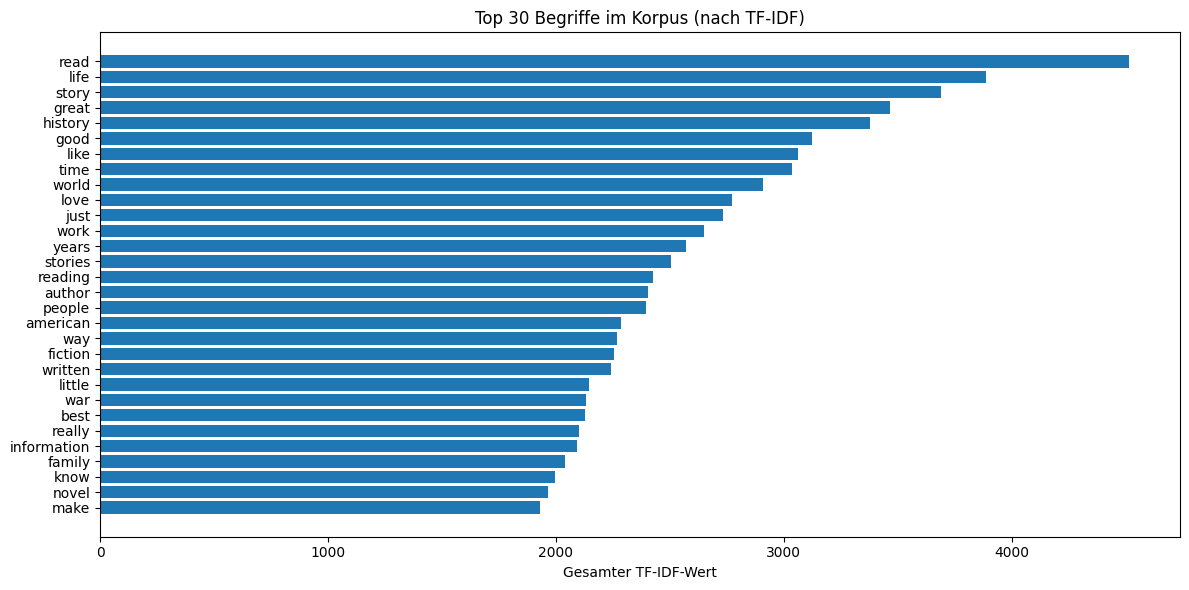

In [17]:
books["combined_features"] = (
    (books["Title"] + " ") * 2 +
    books["authors"] + " " +
    books["categories"] + " " +
    books["description"] + " " +
    books["review/text"].str[:1000]  # nur erste 1000 Zeichen
).str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True)

tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000, max_df=0.8, min_df=5) #Wörter, die in über 80% der Dokumente vorkommen, ignorieren, da Füllwörter etc.
tfidf_matrix = tfidf.fit_transform(books["combined_features"])

tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
feature_names = tfidf.get_feature_names_out()

# Top-N Begriffe mit höchster Gesamt-TF-IDF
top_n = 30
top_indices = tfidf_sum.argsort()[::-1][:top_n]

top_features = [feature_names[i] for i in top_indices]
top_scores = tfidf_sum[top_indices]

# Visualisierung
plt.figure(figsize=(12, 6))
plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Gesamter TF-IDF-Wert")
plt.title(f"Top {top_n} Begriffe im Korpus (nach TF-IDF)")
plt.tight_layout()
plt.show()

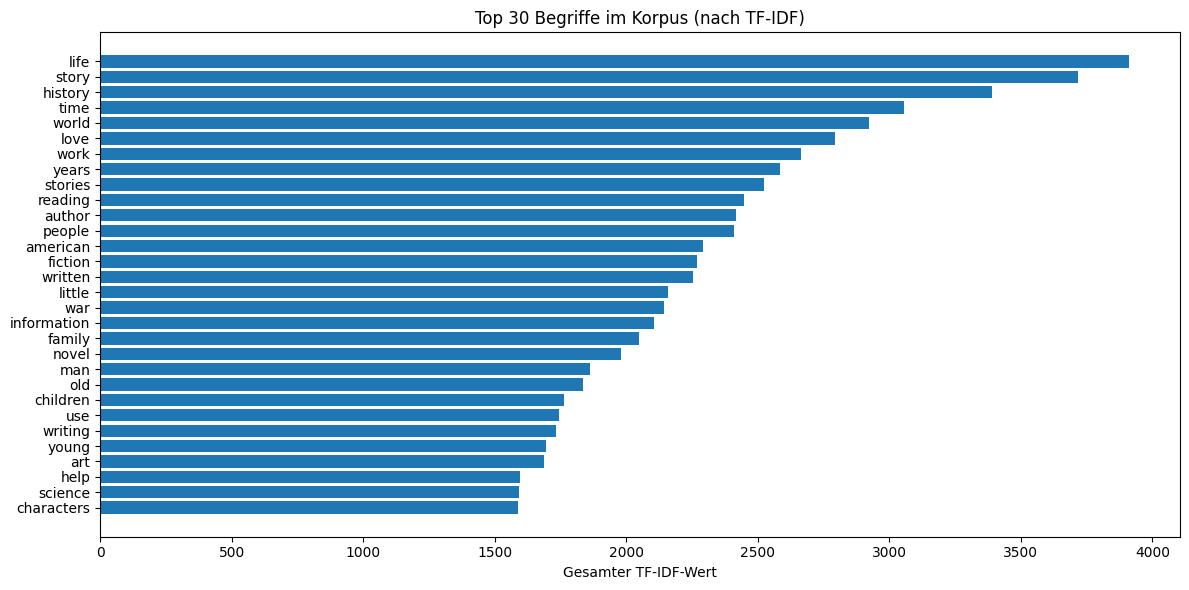

In [18]:
# Ursprünglich definierte custom Stopwords
custom_stopwords = [
    "book", "books", "guide", "edition", "series", "new",
    # Ergänzungen:
    "read", "just", "really", "like", "good", "great", "does", "way", "make", "know", "best"
]

# Kombinieren mit den Standardstopwörtern von sklearn
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))


tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000, max_df=0.8, min_df=5) #Wörter, die in über 80% der Dokumente vorkommen, ignorieren, da Füllwörter etc.
tfidf_matrix = tfidf.fit_transform(books["combined_features"])

tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
feature_names = tfidf.get_feature_names_out()

# Top-N Begriffe mit höchster Gesamt-TF-IDF
top_n = 30
top_indices = tfidf_sum.argsort()[::-1][:top_n]

top_features = [feature_names[i] for i in top_indices]
top_scores = tfidf_sum[top_indices]

# Visualisierung
plt.figure(figsize=(12, 6))
plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Gesamter TF-IDF-Wert")
plt.title(f"Top {top_n} Begriffe im Korpus (nach TF-IDF)")
plt.tight_layout()
plt.show()



In [19]:
# Funktion: Ähnliche Bücher zu einem gegebenen Titel finden
def get_similar_books(title, books_df, tfidf_matrix, top_n=10):
    # Titel zu Index mappen
    indices = pd.Series(books_df.index, index=books_df["Title"]).drop_duplicates()
    idx = indices.get(title)

    if idx is None:
        return f"Titel '{title}' nicht gefunden."

    # Vektor des Zielbuchs extrahieren
    book_vec = tfidf_matrix[idx]

    # Ähnlichkeiten berechnen (nur zu diesem Buch!)
    sim_scores = cosine_similarity(book_vec, tfidf_matrix).flatten()

    # Top-N ähnlichen Bücher holen (ohne sich selbst)
    similar_indices = sim_scores.argsort()[::-1][1:top_n+1]

    # Ausgabe
    result = books_df.iloc[similar_indices][["Title", "authors", "categories"]].copy()
    result["Ähnlichkeit"] = sim_scores[similar_indices]
    return result

def get_random_book_title(books_df):
    """Gibt den echten Titel (ohne Formatierung) aus."""
    return books_df["Title"].sample(1).values[0]

In [22]:
get_similar_books("Sorcerers of Pan Tang (Stormbringer RPG)", books, tfidf_matrix)


,Title,authors,categories,Ähnlichkeit
197676,Fantasy of the 20TH Century,['Randy Broecker'],['Fantasy fiction'],0.379144
110299,"The Complete Guide to Writing Fantasy, Vol. 2:...",['Piotr Brnyczka'],['Games & Activities'],0.341353
142743,Write Your Own Fantasy Story (Write Your Own),,['Juvenile Nonfiction'],0.322056
205745,Imaginary worlds;: The art of fantasy (Ballant...,['Lin Carter'],"['Creation (Literary, artistic, etc.)']",0.320098
183983,The Fantastic Sublime: Romanticism and Transce...,['David Sandner'],['Literary Criticism'],0.309922
44306,The Power of Fantasy: Illusion and Eroticism i...,['Gini Graham Scott'],['Psychology'],0.307427
180376,The Complete Idiot's Guide to Fantasy Baseball,['Michael Zimmerman'],['Games'],0.307020
155218,Fantasy Life,['Matthew Berry'],['Games & Activities'],0.304619
95944,A CENTURY OF FANTASY 1980-1989: The Greatest S...,"['Robert Silverberg', 'Martin Harry Greenberg']",['Fiction'],0.304362
43246,Riddle-Master,['Patricia A. McKillip'],['Fiction'],0.301713


In [26]:
title = get_random_book_title(books)
print("📘 Zufallsbuch:", title)

# Empfehlung dazu
get_similar_books(title, books, tfidf_matrix)

📘 Zufallsbuch: A Field Guide to Boys and Girls: Differences, Similarities; Cutting-Edge Information Every Parent Needs to Know


,Title,authors,categories,Ähnlichkeit
60503,The Book of Boys (for Girls) & The Book of Gir...,['David T. Greenberg'],['Juvenile Fiction'],0.702708
200144,"Girls are from Saturn, Boys are from Jupiter",['Kathryn Lamb'],['Interpersonal relations in adolescence'],0.691754
95786,BOYS AND GIRLS,['David T. Greenberg'],['Juvenile Fiction'],0.642904
104125,Boys Against Girls,['Phyllis Reynolds Naylor'],['Juvenile Fiction'],0.594742
192957,A Traitor Among the Boys,['Phyllis Reynolds Naylor'],['Juvenile Fiction'],0.573857
24876,What Girls Want to Know About Boys,['Frank C. Hawkins'],['Juvenile Nonfiction'],0.550502
149151,Randy's Raiders (Boys' School Girls #1),['Francess Lin Lantz'],['Juvenile Fiction'],0.535602
65634,Boys in control (Boys-girls battle series),['Phyllis Reynolds Naylor'],['Juvenile Fiction'],0.515148
28010,When Girls Meet Boys,['Ali Smith'],['Fiction'],0.500877
92751,Raising Confident Girls: 100 Tips for Parents ...,['Elizabeth Hartley-Brewer'],['Psychology'],0.500168


In [48]:
# Hilfsfunktion: Titel zu Index
def get_book_index(title, books_df):
    indices = pd.Series(books_df.index, index=books_df["Title"]).drop_duplicates()
    return indices.get(title)

# 1. Intra-List Similarity (thematische Kohärenz)
def intra_list_similarity(indices, tfidf_matrix):
    vecs = tfidf_matrix[indices]
    sim_matrix = cosine_similarity(vecs)
    upper_tri = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    return upper_tri.mean()


# 2. Category Diversity (Anzahl unterschiedlicher Kategorien)
def category_diversity(indices, books_df):
    unique_cats = set()
    for i in indices:
        try:
            cats = eval(books_df.iloc[i]["categories"]) if isinstance(books_df.iloc[i]["categories"], str) else []
            unique_cats.update(cats)
        except:
            continue
    return len(unique_cats)

# 🚀 Hauptfunktion zur Evaluation
def evaluate_model(books_df, tfidf_matrix, top_n=10, num_samples=20):
    titles = books_df["Title"].dropna().unique()
    sampled_titles = random.sample(list(titles), min(num_samples, len(titles)))

    results = []

    for title in sampled_titles:
        idx = get_book_index(title, books_df)
        if idx is None:
            continue

        sims = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
        top_indices = sims.argsort()[::-1][1:top_n+1]

        ils = intra_list_similarity(top_indices, tfidf_matrix)
        div = category_diversity(top_indices, books_df)

        results.append({
            "Title": title,
            "IntraListSimilarity": round(ils, 4),
            "CategoryDiversity": div
        })

    return pd.DataFrame(results)


In [53]:
evaluation_df = evaluate_model(books, tfidf_matrix, top_n=10, num_samples=200)
evaluation_df.head(10)


,Title,IntraListSimilarity,CategoryDiversity
0,EJB 2.1 Kick Start,0.4477,3
1,"Hear Me, My Chiefs! Nez Perce Legend and History",0.3341,5
2,Cowboy,0.5822,7
3,Internet English: Www-Based Communication Acti...,0.5187,5
4,50 Fast Digital Photo Techniques with Photosho...,0.3966,3
5,The Wellness Encyclopedia of Food and Nutrition,0.4404,7
6,"Catholicism and the second French republic, 18...",0.2652,2
7,Exploring Church History: Nelson's Christian C...,0.6222,3
8,A Deadline for Murder,0.2565,2
9,Military aircraft of Australia,0.6295,5


In [54]:
get_similar_books("Cowboy", books, tfidf_matrix)

,Title,authors,categories,Ähnlichkeit
185079,Cowboy & Western Cuts: Electronic Clip Art for...,['Mark Robichaux'],['Business & Economics'],0.634861
62471,American Cowboy,,,0.450864
64679,Rodeo Bloopers 6 & 7,,,0.444843
69278,Cowboy Bunnies,['Christine Loomis'],['Juvenile Fiction'],0.443017
22773,Lone Cowboy,['Maisey Yates'],['Fiction'],0.437850
84582,How To Be A Cowboy,['Jim Arndt'],['Social Science'],0.426177
38108,The Cowboy Boot Book,['Tyler Beard'],['Cowboy boots'],0.422682
145736,The Heartbreaker,['Maisey Yates'],['Fiction'],0.421733
163612,The Cowboy At Work: All About His Job And How ...,['Fay E. Ward'],['Cowboys'],0.419929
15387,Cowboy Boots,['Tyler Beard'],['Photography'],0.399838


In [55]:
print(f"Anzahl berechneter Listen: {len(evaluation_df)}")


mean_ils = evaluation_df["IntraListSimilarity"].mean()
mean_diversity = evaluation_df["CategoryDiversity"].mean()

print(f"🔹 Durchschnittliche Intra-List Similarity: {mean_ils:.4f}")
print(f"🔹 Durchschnittliche Category Diversity:   {mean_diversity:.2f}")

print("📈 IntraListSimilarity:")
print(evaluation_df["IntraListSimilarity"].describe())

print("\n📊 CategoryDiversity:")
print(evaluation_df["CategoryDiversity"].describe())


Anzahl berechneter Listen: 200
🔹 Durchschnittliche Intra-List Similarity: 0.4096
🔹 Durchschnittliche Category Diversity:   4.69
📈 IntraListSimilarity:
count    200.000000
mean       0.409562
std        0.153040
min        0.117100
25%        0.288200
50%        0.403700
75%        0.528925
max        0.785600
Name: IntraListSimilarity, dtype: float64

📊 CategoryDiversity:
count    200.000000
mean       4.690000
std        1.884584
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max        9.000000
Name: CategoryDiversity, dtype: float64


| Metrik         | Aussage                                                                  |
| -------------- | ------------------------------------------------------------------------ |
| **ILS = 0.41** | Gute inhaltliche Kohärenz der Empfehlungen, keine Redundanz              |
| **CD = 4.69**  | Empfehlungen sind thematisch breit aufgestellt, ohne willkürlich zu sein |
